<a href="https://colab.research.google.com/github/LueMar-R/P32_medical_image_segmentation/blob/main/medical_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation

In [20]:
import os
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time

import skimage
from skimage import io, util, filters, transform

import tensorflow as tf
from keras import models, layers, optimizers, backend, metrics, callbacks
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint

In [49]:
params = {
    'figure.figsize': (12, 8),
    'font.size': 10,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'figure.titlesize': 15,
    'axes.titlesize': 12,
    'axes.labelsize': 14
}
plt.rcParams.update(params)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/P32_medical_image_segmentation'

/content/drive/MyDrive/P32_medical_image_segmentation


In [ ]:
!unzip -q data_seg.zip

In [4]:
data_path = "../P32_medical_image_segmentation/data_seg/"

directories_list = os.listdir(data_path)
print(directories_list)

['test', 'train', 'label']


## Preprocessing

### Converting images to PNG

In [ ]:
def tif_to_png(directory):
    os.chdir(f"data_seg/{directory}")

    for f in os.listdir():
        if f.endswith("tif"):
            with Image.open(f) as im : # opening images and resaving it to png with PIL
                name, ext = f.split('.')
                name = int(name)
                if name<10 :
                    dest = "00"+str(name)+".png"
                elif (name>=10 and name<100) :
                    dest = "0"+str(name)+".png"
                else :
                    dest = str(name)+".png"
                im.save(dest)

    os.chdir("../..")


def delete_tif(directory):
    os.chdir(f"data_seg/{directory}")

    for f in os.listdir():
        if not f.endswith("png"):
            os.remove(f)

    os.chdir("../..")


In [ ]:
for directory in directories_list:
    tif_to_png(directory)
    delete_tif(directory)

In [38]:
print("Labelling verification :")
for directory in directories_list :
    print(directory, "\n", os.listdir(f"data_seg/{directory}"))

if os.listdir(f"data_seg/{directories_list[0]}") == os.listdir(f"data_seg/{directories_list[2]}") :
    print("Images ready")
else :
    print("Please check folders content")

Labelling verification :
test 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png']
train 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png']
label 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '00

### Building train set

In [39]:
# importing data with skimage to obtain matrices

base_X_train = np.asarray([io.imread("data_seg/train/"+img) for img in os.listdir("data_seg/train")], np.uint8)
base_Y_train = np.asarray([io.imread("data_seg/label/"+img) for img in os.listdir("data_seg/label")], np.uint8)
base_X_test = np.asarray([io.imread("data_seg/test/"+img) for img in os.listdir("data_seg/test")], np.uint8)

In [40]:
# checking the number of values in segmentation

print("There are", len(np.unique(base_Y_train)), 'different segmentation values')

There are 2 different segmentation values


### Visualization

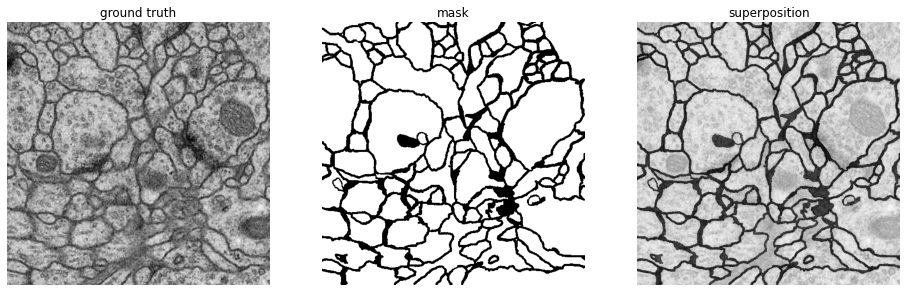

In [41]:
#example with the first image
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.imshow(base_X_train[0], "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("ground truth")

plt.subplot(132)
plt.imshow(base_Y_train[0], "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("mask")

I = base_X_train[0]/2 + base_Y_train[0]/2 # supperposition des deux images
plt.subplot(133)
plt.imshow(I, "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("superposition")

plt.show()

In [ ]:
## brouillon 
# On the left > groung truth
# center > mask : the way the model is supposed tu segment the image. Wha can see that some of the dark points are supposed to be segmented as contours, while some others are considered as cells.

### Data augmentation

In [ ]:
# a data augmentation method, using skimage
def random_transformation(real, mask):
    random_degree = random.uniform(-25, 25)
    real, mask = [skimage.transform.rotate(img, random_degree) for img in [real, mask]]
    real = skimage.util.random_noise(real) # add random noise of type Speckle, Poisson, Localvar, or Gaussian
    random_flipping = random.choice(["vert", "hori", "none"])
    real, mask = [(img[::-1,:] if random_flipping=="vert" else img[:,::-1] if random_flipping=="vert" else img) for img in [real, mask]]
    return real, mask

In [ ]:
X = base_X_train
Y = base_Y_train

i=0
a = time.time()
while i<770:
    random_indice = random.randrange(len(base_X_train))
    new_img, new_mask = random_transformation(base_X_train[random_indice], base_Y_train[random_indice])
    X = np.vstack((X, new_img.reshape(1, 512, 512)))
    Y = np.vstack((Y, new_mask.reshape(1, 512, 512).round(0)))
    i+=1
print("Time to process the data augmentation :", (time.time()-a)//60, "min.", np.round((time.time()-a)%60, 0))
print("New size of the Dataset : {}images".format(len(X)))

Time to process the data augmentation : 4.0 min. 26.0
New size of the Dataset : 800images


In [ ]:
# Now we create a validation set by spliting the dataset into train (600 images) and validation (200 images).
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

Ground Truth


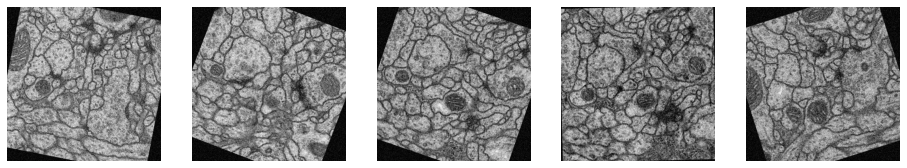

In [44]:
plt.figure(figsize=(16, 6))
print("Ground Truth")
for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(X_train[i], "gray")
  plt.axis("off")

Masks


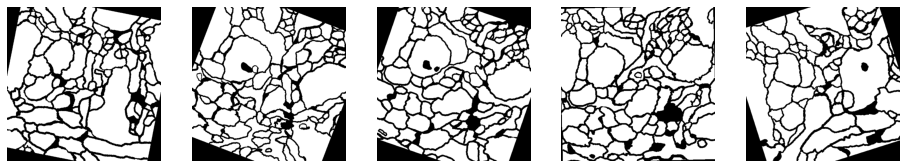

In [45]:
plt.figure(figsize=(16, 6))
print("Masks")
for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(Y_train[i], "gray")
  plt.axis("off")

In [46]:
# check that we still have 2 values for segmentation
print(np.unique(Y_train[0]))
# check that values are normalized
print(np.min(X_train[0:10]), np.max(X_train[0:10]))

[0. 1.]
0.0 1.0


In [ ]:
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)

In [5]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_val  = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

## Model Training

In [6]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    Dice definition based on https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [23]:
# the following function creates a U-Net model when called.

def make_unet(ROWS, COLS):
    inputs = Input((ROWS, COLS, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[conv10])

    return model


In [24]:
modelX = make_unet(512, 512)

In [25]:
modelX.compile(optimizer=optimizers.Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef, metrics.BinaryAccuracy()])

lr_reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10)
history = modelX.fit(X_train, Y_train, epochs=50,  batch_size=20, validation_split = 0.2, callbacks=[lr_reduce])

Epoch 1/50
24/24 [==============================] - 39s 2s/step - loss: 0.2211 - dice_coef: 0.7789 - binary_accuracy: 0.6188 - val_loss: 0.1522 - val_dice_coef: 0.8478 - val_binary_accuracy: 0.7809
Epoch 2/50
24/24 [==============================] - 37s 2s/step - loss: 0.1315 - dice_coef: 0.8685 - binary_accuracy: 0.7855 - val_loss: 0.1366 - val_dice_coef: 0.8634 - val_binary_accuracy: 0.7690
Epoch 3/50
24/24 [==============================] - 37s 2s/step - loss: 0.1221 - dice_coef: 0.8779 - binary_accuracy: 0.7949 - val_loss: 0.1240 - val_dice_coef: 0.8760 - val_binary_accuracy: 0.8033
Epoch 4/50
24/24 [==============================] - 37s 2s/step - loss: 0.1242 - dice_coef: 0.8758 - binary_accuracy: 0.8078 - val_loss: 0.1148 - val_dice_coef: 0.8852 - val_binary_accuracy: 0.8270
Epoch 5/50
24/24 [==============================] - 37s 2s/step - loss: 0.0952 - dice_coef: 0.9048 - binary_accuracy: 0.8469 - val_loss: 0.1123 - val_dice_coef: 0.8877 - val_binary_accuracy: 0.8324
Epoch 6/50

In [26]:
modelX.save("modelX")

INFO:tensorflow:Assets written to: modelX/assets


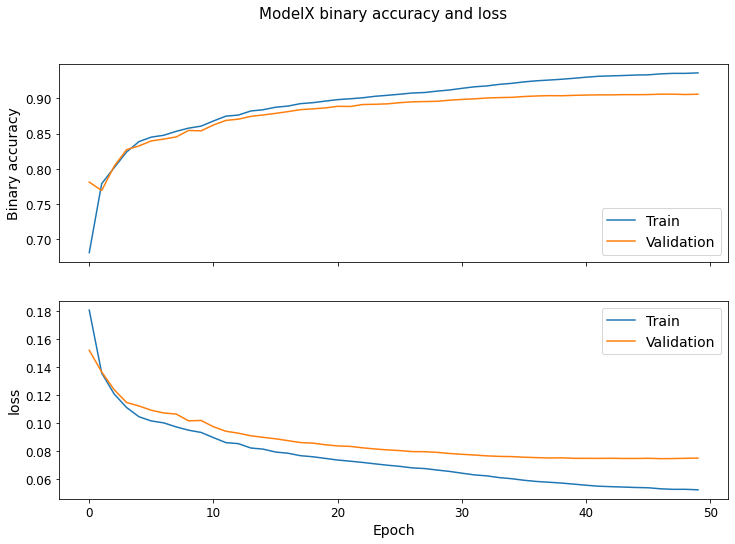

In [52]:
from keras.callbacks import History
# plotting of loss and accuracy evolution
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('ModelX binary accuracy and loss')
ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.set_ylabel('Binary accuracy')
ax1.legend(['Train', 'Validation'], loc='lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
fig.show()

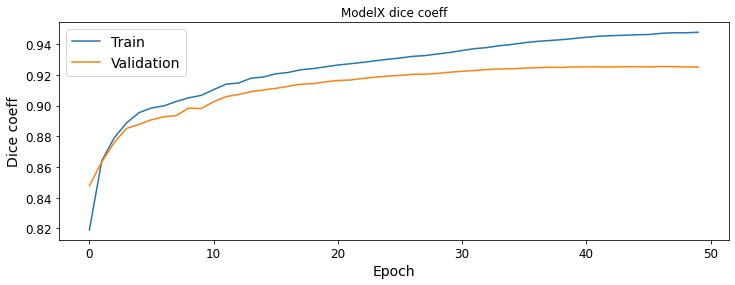

In [54]:
# plotting of the dice coef evolution
plt.figure(figsize=(12,4))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('ModelX dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Predictions

In [23]:
modelX = models.load_model("modelX", custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss, })

In [56]:
Y_pred = modelX.predict(X_val)

In [57]:
Y_pred = np.round(Y_pred,0)
Y_pred = Y_pred.reshape(Y_pred.shape[0:3])

In [58]:
print(Y_pred.shape)

(200, 512, 512)


In [59]:
def show_result_on_an_image(image_number):
    plt.figure(figsize=(16,5))

    plt.subplot(131)
    plt.imshow(Y_pred[image_number], cmap="gray")
    plt.axis("off")
    plt.title("predicted")

    plt.subplot(132)
    plt.imshow(Y_val[image_number], cmap="gray")
    plt.axis("off")
    plt.title("awaited")

    I = Y_pred[image_number]/2 + Y_val[image_number]/2 
    error = np.where(I == 0.5)

    plt.subplot(133)
    plt.imshow(I, cmap="gist_heat")
    plt.axis("off")
    plt.title("error")

    plt.show()

    print(f"{len(error[0])} pixels uncorrectly identified on test image n°{image_number},")
    print("representig", np.round(len(error[0])*100/(Y_val.shape[1]*Y_val.shape[2]),2), "% of pixels on the image.")

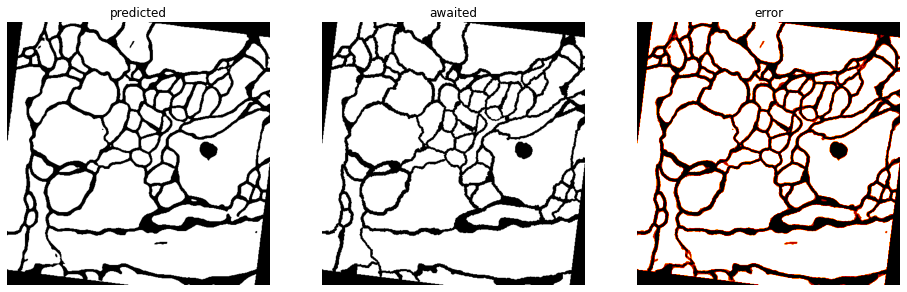

10466 pixels uncorrectly identified on test image n°42,
representig 3.99 % of pixels on the image.


In [60]:
show_result_on_an_image(42)

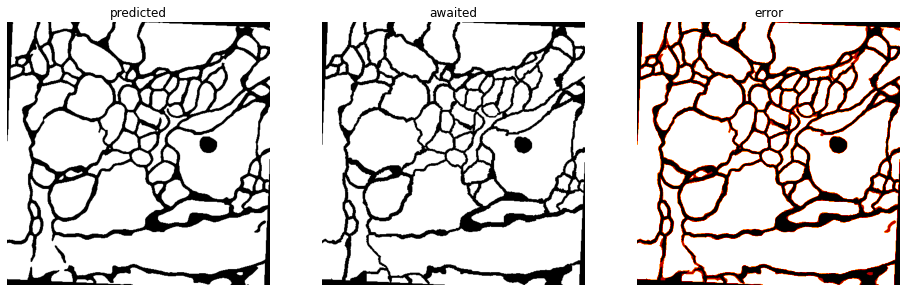

11741 pixels uncorrectly identified on test image n°100,
representig 4.48 % of pixels on the image.


In [76]:
show_result_on_an_image(100)

In [ ]:
# The figure above represents ......
# white color = neurites
# red color in the third image highlights the pixels that are uncorrectly identified, .;...

In [62]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def SSIM(y_true, y_pred):
  ssim = structural_similarity(y_true, y_pred,
                  data_range=y_pred.max() - y_pred.min())
  return ssim

def PSNR(y_true, y_pred):
    psnr = peak_signal_noise_ratio(y_true, y_pred)
    return psnr

In [63]:
print("PSNR and SSIM metrics on image 42 :")
print("Structural Similarity :", SSIM(Y_val[42], Y_pred[42]))
print("Peak signal noise ratio :", PSNR(Y_val[42], Y_pred[42]))

PSNR and SSIM metrics on image 42 :
Structural Similarity : 0.8457928809547097
Peak signal noise ratio : 13.98759191548015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  if __name__ == '__main__':


¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
    Global error on validation set : 5.03 %
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤


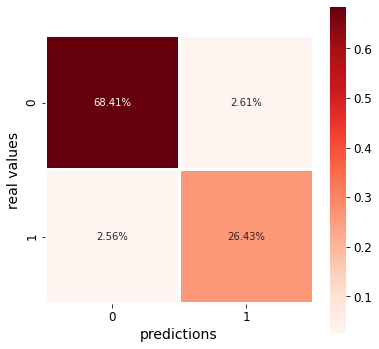

In [74]:
import seaborn as sns

global_error = np.where(np.abs(Y_pred - Y_val)  == 1)

print("¤"*47)
print("   ", "Global error on validation set :", np.round(len(global_error[0])*100/(Y_val.shape[1]*Y_val.shape[2]*Y_val.shape[0]),2), "%")
print("¤"*47)

FP = np.sum(np.where(Y_pred - Y_val  == -1))
FN = np.sum(np.where(Y_pred - Y_val  == 1))
TP = np.sum(np.where(Y_pred + Y_val ==2))
TN = np.sum(np.where(Y_pred + Y_val == 0))
cmat = [[TP, FN], [FP, TN]]

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1, linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()